## Look at calibrated spectra
Glen Langston, NSF, 2021 October 27
### After calibration and selecting the low galactic latitude data, the averages are saved in a sub-directory
Now check the calibration and velocities saved

In [4]:
datadir = "./keep/"
!ls {datadir}

T0-21-09-29T103456.kel T0-21-10-10T231148.kel T0-21-10-26T104009.kel
T0-21-09-30T004021.kel T0-21-10-16T104527.kel T0-21-10-26T205337.kel
T0-21-10-10T103920.kel T0-21-10-16T221734.kel


In [5]:
# Import the processing routines
import ras

In [6]:
p = ras.Plot(datadir)

In [7]:
p.Help("-V "+datadir)

Arg[0] = -V
Arg[1] = ./keep/
Observation Files and Directories:
['./keep/']


['./keep/']

Ploting Intensity versus Velocity
Date: 2021-09-29
Imin Error computing baseline:  -33
  Time   AZ,EL (deg)  Lon,Lat (deg)    Max   Median    Count  
10:34:56 180.0, 80.0  180.6,  0.1   48.290    0.234    472500
Date: 2021-09-30
Imax Error computing baseline:  554
00:40:21 180.0, 80.0   65.1,  0.0   44.004    0.292    450000
Date: 2021-10-10
Imin Error computing baseline:  -33
10:39:20 180.0, 60.0  203.5,  0.2   47.618    0.383    382500
Imax Error computing baseline:  564
23:11:48 180.0, 60.0   42.4,  0.2   34.995    0.260    382500
Date: 2021-10-16
Imin Error computing baseline:  -30
10:45:27 180.0, 45.0  220.3,  0.0   37.319    0.205    382500
Imax Error computing baseline:  567
22:17:34 180.0, 45.0   25.6,  0.2   46.556    0.823    382500
Date: 2021-10-26
Imin Error computing baseline:  -25
10:40:09 180.0, 30.0  237.4,  0.2   33.239    0.266    427500
Imax Error computing baseline:  562
20:53:37 180.0, 25.0    2.9,  0.3   47.380    1.096    450000


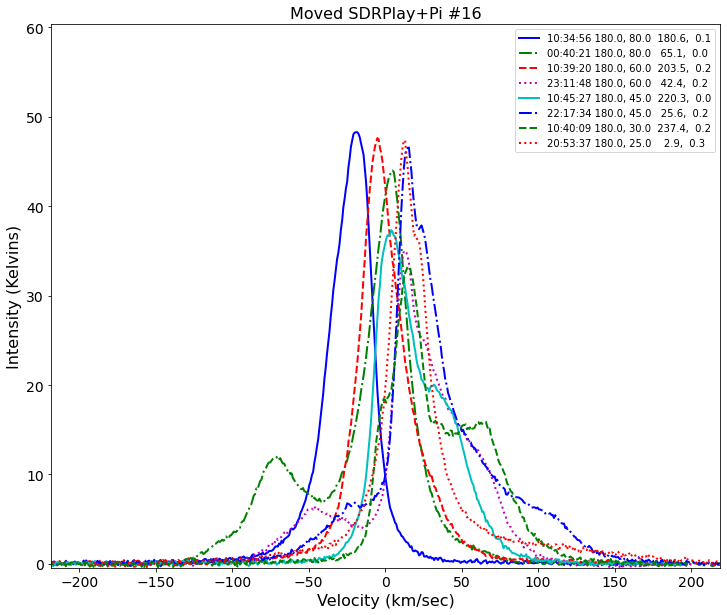

In [8]:
p.raw(datadir)

In [9]:
# Now prepare to fit two gaussians to last spectrum averaged

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy as scipy
from scipy import optimize
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.ticker as ticker
%matplotlib inline

In [11]:
# Retrieve the data from the lastest plot
x_array = p.xv
y_array = p.yv
bunit = "Kelvins"
print("Length of arrays to fit: %d, %d" % (len(x_array),len(y_array)))
xunit = "MHz"
if not p.plotFrequency:
    xunit = "km/sec"
print("X min, max: %8.3f, %8.3f (%s)" % (np.min(x_array), np.max(x_array), xunit))
print("Y min, max: %8.3f, %8.3f (%s)" % (np.min(y_array), np.max(y_array), bunit))

# prepare to fit a guassian
ymax = np.amax(y_array)
imax = np.argmax(y_array)

xmax = x_array[imax]
sigma1 = 10.

amp1 = xmax
cen1 = ymax
amp2 = xmax*.9
cen2 = cen1*.9
sigma2 = sigma1
amp3 = xmax*.9
cen3 = cen1*1.1
sigma3 = sigma1
# Print gaussian input guess
print("Gaussian estimate; X,Y,Sigma: %.2f, %.2f, %.2f" % (amp1, cen1, sigma1))

Length of arrays to fit: 501, 501
X min, max: -193.028,  219.200 (km/sec)
Y min, max:   -0.357,   47.380 (Kelvins)
Gaussian estimate; X,Y,Sigma: 13.09, 47.38, 10.00


In [12]:
# define a single gaussian function

In [13]:
def _1gaussian(x, amp1,cen1,sigma1):
    return amp1*(np.exp((-0.5)*(((x_array-cen1)/sigma1)**2)))

In [14]:
# next define a two gaussian funtion

In [18]:
popt_1gauss, pcov_1gauss = scipy.optimize.curve_fit(_1gaussian, x_array, y_array, 
                                                    p0=[amp1, cen1, sigma1])

perr_1gauss = np.sqrt(np.diag(pcov_1gauss))

pars_1a = popt_1gauss[0:3]
# produce curves for each of the component gaussians
gauss_peak_1a = _1gaussian(x_array, *pars_1a)

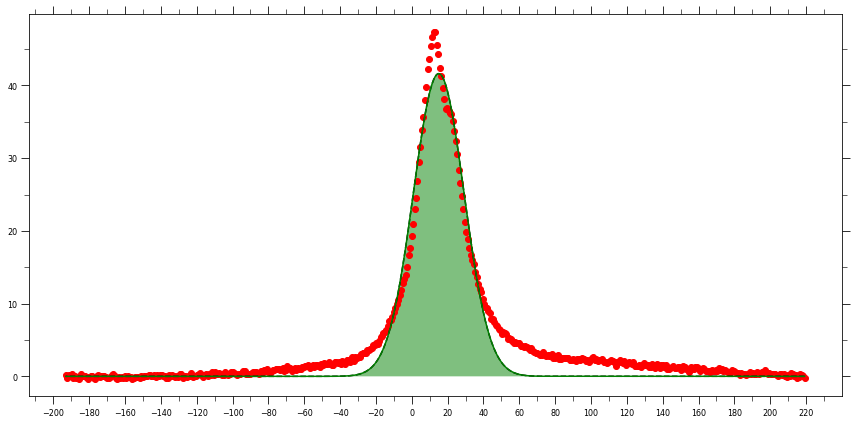

In [19]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0])

ax1.plot(x_array, y_array, "ro", label="Data")
ax1.plot(x_array, _1gaussian(x_array, *popt_1gauss), 'k--', label="Fit")#,\
         #label="y= %0.2f$e^{%0.2fx}$ + %0.2f" % (popt_exponential[0], popt_exponential[1], popt_exponential[2]))

# peak 1
ax1.plot(x_array, gauss_peak_1a, "g")
ax1.fill_between(x_array, gauss_peak_1a.min(), gauss_peak_1a, facecolor="green", alpha=0.5)

ax1.xaxis.set_major_locator(ticker.MultipleLocator(20))
#ax1.yaxis.set_major_locator(ticker.MultipleLocator(50))

ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(AutoMinorLocator(2))

ax1.tick_params(axis='both',which='major', direction="out", top="on", right="on", bottom="on", length=8, labelsize=8)
ax1.tick_params(axis='both',which='minor', direction="out", top="on", right="on", bottom="on", length=5, labelsize=8)

fig.tight_layout()
fig.savefig("fit1Gaussian_peaks.png", format="png",dpi=1000)

In [25]:
# now subtract the fit
y_array_sub = y_array - (.95*gauss_peak_1a)


In [26]:
# estimate the peak of the residual
# prepare to fit a guassian
ymax2 = np.amax(y_array_sub)
imax2 = np.argmax(y_array_sub)

xmax2 = x_array[imax2]
sigma2 = 10.

amp2 = xmax2
cen2 = ymax2

In [27]:
# now fit a second gaussian
popt_2gauss, pcov_2gauss = scipy.optimize.curve_fit(_1gaussian, x_array, y_array_sub, 
                                                    p0=[amp2, cen2, sigma2])

perr_2gauss = np.sqrt(np.diag(pcov_2gauss))

pars_2a = popt_2gauss[0:3]
# produce curves for each of the component gaussians
gauss_peak_2a = _1gaussian(x_array, *pars_2a)

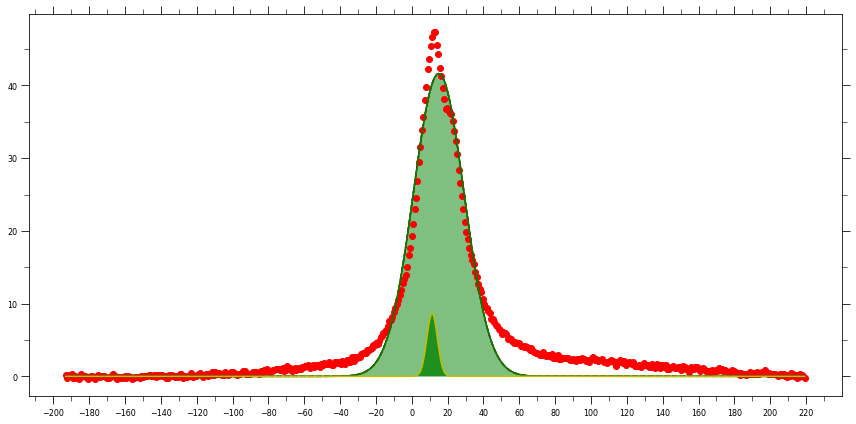

In [28]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0])

ax1.plot(x_array, y_array, "ro", label="Data")
ax1.plot(x_array, _1gaussian(x_array, *popt_1gauss), 'k--', label="Fit")#,\
         #label="y= %0.2f$e^{%0.2fx}$ + %0.2f" % (popt_exponential[0], popt_exponential[1], popt_exponential[2]))

# peak 1
ax1.plot(x_array, gauss_peak_1a, "g")
ax1.fill_between(x_array, gauss_peak_1a.min(), gauss_peak_1a, facecolor="green", alpha=0.5)

ax1.plot(x_array, _1gaussian(x_array, *popt_1gauss), 'r--', label="Fit")#,\
         #label="y= %0.2f$e^{%0.2fx}$ + %0.2f" % (popt_exponential[0], popt_exponential[1], popt_exponential[2]))

# peak 1
ax1.plot(x_array, gauss_peak_1a, "g")
ax1.fill_between(x_array, gauss_peak_1a.min(), gauss_peak_2a, facecolor="green", alpha=0.5)
ax1.plot(x_array, gauss_peak_2a, "y")
ax1.fill_between(x_array, gauss_peak_2a.min(), gauss_peak_2a, facecolor="green", alpha=0.5)

ax1.xaxis.set_major_locator(ticker.MultipleLocator(20))
#ax1.yaxis.set_major_locator(ticker.MultipleLocator(50))

ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(AutoMinorLocator(2))

ax1.tick_params(axis='both',which='major', direction="out", top="on", right="on", bottom="on", length=8, labelsize=8)
ax1.tick_params(axis='both',which='minor', direction="out", top="on", right="on", bottom="on", length=5, labelsize=8)

fig.tight_layout()
fig.savefig("fit1Gaussian_peaks.png", format="png",dpi=1000)

In [29]:
def _2gaussian(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(np.exp((-0.5)*(((x_array-cen1)/sigma1)**2))) + \
            amp2*(np.exp((-0.5)*(((x_array-cen2)/sigma2)**2)))

In [30]:
popt_2gauss, pcov_2gauss = scipy.optimize.curve_fit(_2gaussian, x_array, y_array, p0=[amp1, cen1, sigma1, \
                                                                                          amp2, cen2, sigma2])

perr_2gauss = np.sqrt(np.diag(pcov_2gauss))

pars_1 = popt_2gauss[0:3]
pars_2 = popt_2gauss[3:6]
# produce curves for each of the component gaussians
gauss_peak_1 = _1gaussian(x_array, *pars_1)
gauss_peak_2 = _1gaussian(x_array, *pars_2)

In [31]:
# Next fit two gauassians to the data

In [32]:
popt_2gauss, pcov_2gauss = scipy.optimize.curve_fit(_2gaussian, x_array, y_array, p0=[amp1, cen1, sigma1, \
                                                                                          amp2, cen2, sigma2])

perr_2gauss = np.sqrt(np.diag(pcov_2gauss))

pars_1 = popt_2gauss[0:3]
pars_2 = popt_2gauss[3:6]
# produce curves for each of the component gaussians
gauss_peak_1 = _1gaussian(x_array, *pars_1)
gauss_peak_2 = _1gaussian(x_array, *pars_2)

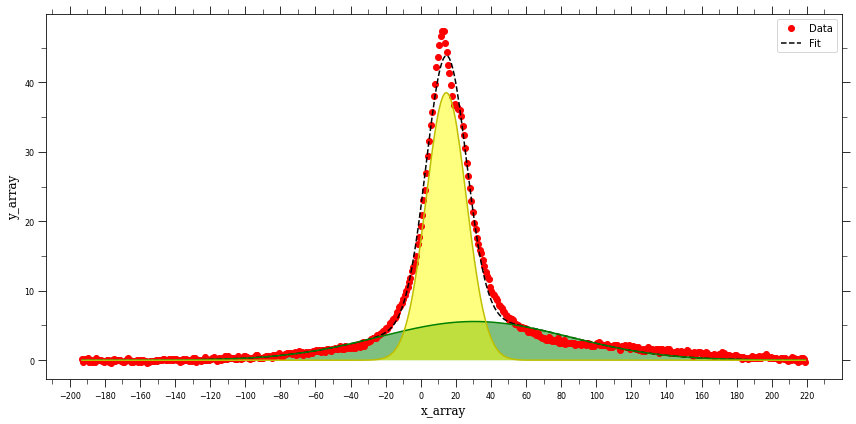

In [33]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0])

ax1.plot(x_array, y_array, "ro", label="Data")
ax1.plot(x_array, _2gaussian(x_array, *popt_2gauss), 'k--', label="Fit")#,\
         #label="y= %0.2f$e^{%0.2fx}$ + %0.2f" % (popt_exponential[0], popt_exponential[1], popt_exponential[2]))

# peak 1
ax1.plot(x_array, gauss_peak_1, "g")
ax1.fill_between(x_array, gauss_peak_1.min(), gauss_peak_1, facecolor="green", alpha=0.5)
  
# peak 2
ax1.plot(x_array, gauss_peak_2, "y")
ax1.fill_between(x_array, gauss_peak_2.min(), gauss_peak_2, facecolor="yellow", alpha=0.5)  

ax1.set_xlabel("x_array",family="serif",  fontsize=12)
ax1.set_ylabel("y_array",family="serif",  fontsize=12)

ax1.legend(loc="best")

ax1.xaxis.set_major_locator(ticker.MultipleLocator(20))
#ax1.yaxis.set_major_locator(ticker.MultipleLocator(50))

ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(AutoMinorLocator(2))

ax1.tick_params(axis='both',which='major', direction="out", top="on", right="on", bottom="on", length=8, labelsize=8)
ax1.tick_params(axis='both',which='minor', direction="out", top="on", right="on", bottom="on", length=5, labelsize=8)

fig.tight_layout()
fig.savefig("fit2Gaussian_peaks.png", format="png",dpi=1000)

In [34]:
# now printout the results o fthe fits. 

In [35]:
# this cell prints the fitting parameters with their errors
peak1 = pars_1[0] / (sigma1*(np.sqrt(2*np.pi)))
peak2 = pars_2[0] / (sigma1*(np.sqrt(2*np.pi)))
perr1 = perr_2gauss[0] / (sigma1*(np.sqrt(2*np.pi)))
perr2 = perr_2gauss[3] / (sigma1*(np.sqrt(2*np.pi)))
print("-------------Peak 1-------------")
print("amplitude = %0.2f (+/-) %0.2f" % (pars_1[0], perr_2gauss[0]))
print("center = %0.2f (+/-) %0.2f" % (pars_1[1], perr_2gauss[1]))
print("sigma = %0.2f (+/-) %0.2f" % (pars_1[2], perr_2gauss[2]))
print("area = %0.2f" % np.trapz(gauss_peak_1))
print("--------------------------------")
print("-------------Peak 2-------------")
print("amplitude = %0.2f (+/-) %0.2f" % (pars_2[1], perr_2gauss[3]))
print("center = %0.2f (+/-) %0.2f" % (pars_2[1], perr_2gauss[4]))
print("sigma = %0.2f (+/-) %0.2f" % (pars_2[2], perr_2gauss[5]))
print("area = %0.2f" % np.trapz(gauss_peak_2))
print("--------------------------------")

-------------Peak 1-------------
amplitude = 5.58 (+/-) 0.18
center = 30.47 (+/-) 1.22
sigma = 53.91 (+/-) 1.30
area = 913.62
--------------------------------
-------------Peak 2-------------
amplitude = 14.55 (+/-) 0.25
center = 14.55 (+/-) 0.07
sigma = 11.43 (+/-) 0.09
area = 1338.32
--------------------------------


In [36]:
# Compute difference between the two gaussian model and observations

In [37]:
residual_2gauss = y_array - (_2gaussian(x_array, *popt_2gauss))

In [38]:
# now create a two part plot, with gaussians on top and residuals underneath

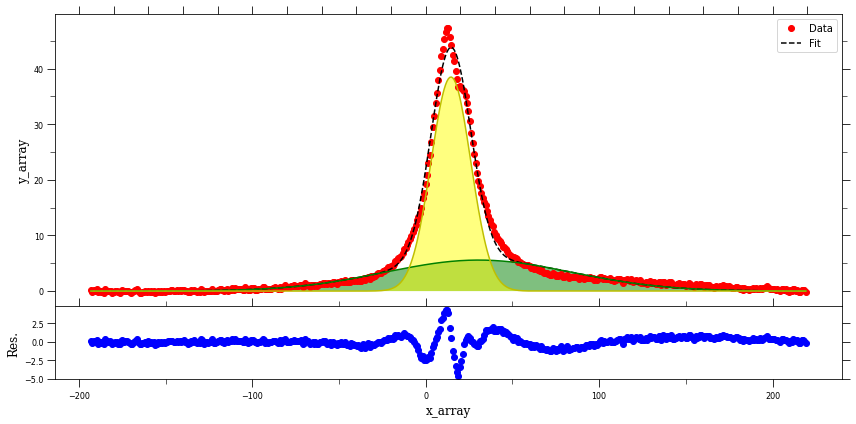

In [39]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(2,1, height_ratios=[1,0.25])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
gs.update(hspace=0) 

ax1.plot(x_array, y_array, "ro", label="Data")
ax1.plot(x_array, _2gaussian(x_array, *popt_2gauss), 'k--', label="Fit")#,\
         #label="y= %0.2f$e^{%0.2fx}$ + %0.2f" % (popt_exponential[0], popt_exponential[1], popt_exponential[2]))

# peak 1
ax1.plot(x_array, gauss_peak_1, "g")
ax1.fill_between(x_array, gauss_peak_1.min(), gauss_peak_1, facecolor="green", alpha=0.5)
  
# peak 2
ax1.plot(x_array, gauss_peak_2, "y")
ax1.fill_between(x_array, gauss_peak_2.min(), gauss_peak_2, facecolor="yellow", alpha=0.5)  

# residual
ax2.plot(x_array, residual_2gauss, "bo")

ax2.set_xlabel("x_array",family="serif",  fontsize=12)
ax1.set_ylabel("y_array",family="serif",  fontsize=12)
ax2.set_ylabel("Res.",family="serif",  fontsize=12)

ax1.legend(loc="best")

ax1.xaxis.set_major_locator(ticker.MultipleLocator(20))
#ax1.yaxis.set_major_locator(ticker.MultipleLocator(50))

ax2.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(AutoMinorLocator(2))

ax1.xaxis.set_major_formatter(plt.NullFormatter())

ax1.tick_params(axis='x',which='major', direction="out", top="on", right="on", bottom="off", length=8, labelsize=8)
ax1.tick_params(axis='x',which='minor', direction="out", top="on", right="on", bottom="off", length=5, labelsize=8)
ax1.tick_params(axis='y',which='major', direction="out", top="on", right="on", bottom="off", length=8, labelsize=8)
ax1.tick_params(axis='y',which='minor', direction="out", top="on", right="on", bottom="on", length=5, labelsize=8)

ax2.tick_params(axis='x',which='major', direction="out", top="off", right="on", bottom="on", length=8, labelsize=8)
ax2.tick_params(axis='x',which='minor', direction="out", top="off", right="on", bottom="on", length=5, labelsize=8)
ax2.tick_params(axis='y',which='major', direction="out", top="off", right="on", bottom="on", length=8, labelsize=8)
ax2.tick_params(axis='y',which='minor', direction="out", top="off", right="on", bottom="on", length=5, labelsize=8)

fig.tight_layout()
fig.savefig("fit2Gaussian_peaks_resid.png", format="png",dpi=1000)

# Congratulations
### You've examined the emission from the Galactic Plane and found the Velocity of the Arms of the Milky Way